# What shapes Berlin AirBnB prices ?


## Install and load packages

In [118]:
!pip install shap -qq
!pip install xgboost

In [119]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import lasso_path
import xgboost
import shap

## Get data

In [123]:
data_raw = pd.read_csv('listings_summary.csv')

In [125]:
# Print data info
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22552 entries, 0 to 22551
Data columns (total 96 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                22552 non-null  int64  
 1   listing_url                       22552 non-null  object 
 2   scrape_id                         22552 non-null  int64  
 3   last_scraped                      22552 non-null  object 
 4   name                              22493 non-null  object 
 5   summary                           21589 non-null  object 
 6   space                             14020 non-null  object 
 7   description                       22349 non-null  object 
 8   experiences_offered               22552 non-null  object 
 9   neighborhood_overview             11540 non-null  object 
 10  notes                             7214 non-null   object 
 11  transit                           13036 non-null  object 
 12  acce

# EDA Report and data prep

In [128]:
!pip install sweetviz -qq
import sweetviz as sv
import warnings
warnings.filterwarnings('ignore')

In [130]:
# Drop columns with NaNs greater than the threshold
data = data_raw.dropna(axis=1, thresh= 0.8*data_raw.shape[0])

# Target varaible

In [133]:
data.price.head()

0    $60.00
1    $17.00
2    $90.00
3    $26.00
4    $42.00
Name: price, dtype: object

### casting

Cast price column to float (replace "$", "," and cast to "float")

In [136]:
data.price.str.replace("$","").str.replace(",","").astype("float").describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

In [138]:
# Cast price as float
data.price = data.price.apply(lambda x: x.replace("$", ""))
data.price = data.price.apply(lambda x: x.replace(",", ""))
data.price = data.price.astype("float")
data.price.describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

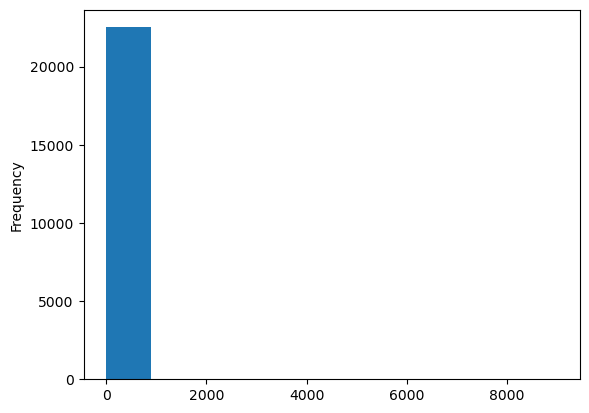

<Axes: ylabel='Frequency'>

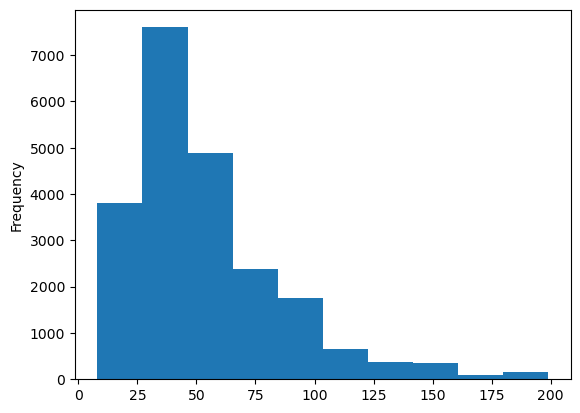

In [140]:
#we have outliers which seem to be to-be-deleted-errors
data.price.plot.hist()
plt.show()
data.query('price > 5 & price < 200').price.plot.hist()

In [142]:
# Getting rid of outliers
print("95% properties have a price lower than {0: .2f}".format(np.percentile(data.price, 95)))
data = data[(data.price <= np.percentile(data.price, 95)) & (data.price > 10)]

95% properties have a price lower than  140.00


<Axes: >

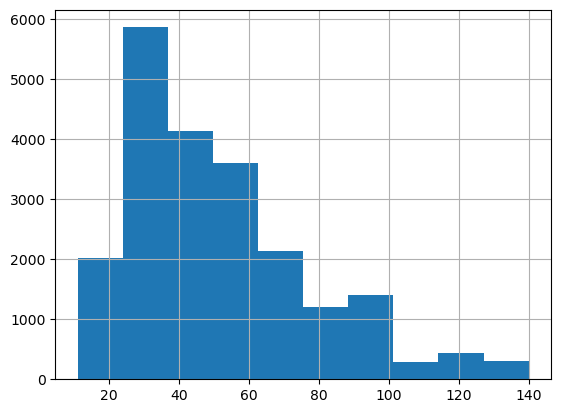

In [144]:
data.price.hist()

In [146]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    data.price,
                                                    test_size=0.20,
                                                    random_state=42)

(<Axes: >, <Axes: >)

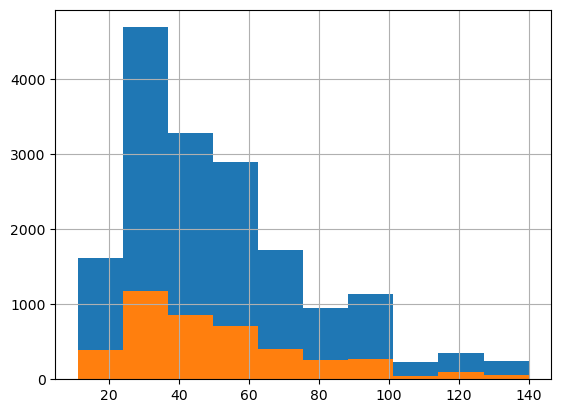

In [148]:
y_train.hist(), y_test.hist()

In [150]:
from sklearn.impute import SimpleImputer

numeric_cols     = X_train.select_dtypes(include=['number']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

numeric_imputer     = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Apply imputer to numeric columns
X_train[numeric_cols]     = numeric_imputer.fit_transform(X_train[numeric_cols])
X_train[categorical_cols] = categorical_imputer.fit_transform(X_train[categorical_cols])

# Apply imputer to numeric columns
X_test[numeric_cols]     = numeric_imputer.transform(X_test[numeric_cols])
X_test[categorical_cols] = categorical_imputer.transform(X_test[categorical_cols])

# Modelling


## First model

In [154]:
data_first_model = pd.concat([X_train.loc[:, ['host_is_superhost', 'bedrooms', 'bathrooms', 'number_of_reviews',  'review_scores_rating',]],y_train], axis = 1).copy()
data_first_model

,host_is_superhost,bedrooms,bathrooms,number_of_reviews,review_scores_rating,price
18890,f,1.0,1.0,0.0,94.375927,30.0
4926,f,1.0,1.0,1.0,100.000000,64.0
2678,f,1.0,0.5,14.0,94.000000,40.0
6014,f,1.0,1.0,0.0,94.375927,50.0
5012,f,1.0,1.0,0.0,94.375927,40.0
...,...,...,...,...,...,...
11866,f,1.0,1.0,7.0,100.000000,20.0
12575,f,1.0,1.0,17.0,95.000000,27.0
5649,f,1.0,1.0,28.0,96.000000,35.0
912,f,2.0,1.0,10.0,98.000000,95.0


In [156]:
# Our first linear model
model = smf.ols('price ~ host_is_superhost + bedrooms + bathrooms + number_of_reviews  + review_scores_rating',data=data_first_model, ).fit()
# Inspect the results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     496.3
Date:                Thu, 23 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:17:01   Log-Likelihood:                -79158.
No. Observations:               17114   AIC:                         1.583e+05
Df Residuals:                   17108   BIC:                         1.584e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 19

### Prediction

In [159]:
model.predict(data_first_model)

18890    47.874813
4926     48.537758
2678     47.542261
6014     47.874813
5012     47.874813
           ...    
11866    48.853809
12575    48.838010
5649     49.525947
912      65.054552
16561    51.852002
Length: 17114, dtype: float64

In [161]:
# Calculate residuals
residuals = y_train - model.predict(X_train)
# Calculate RMSE
rmse = np.sqrt(np.mean(residuals**2))
rmse

24.690676849071266

In [163]:
data_first_model_preds = pd.concat([data_first_model, model.predict(data_first_model).rename('predict'), residuals.rename('residual')], axis =1)

In [165]:
data_first_model_preds

,host_is_superhost,bedrooms,bathrooms,number_of_reviews,review_scores_rating,price,predict,residual
18890,f,1.0,1.0,0.0,94.375927,30.0,47.874813,-17.874813
4926,f,1.0,1.0,1.0,100.000000,64.0,48.537758,15.462242
2678,f,1.0,0.5,14.0,94.000000,40.0,47.542261,-7.542261
6014,f,1.0,1.0,0.0,94.375927,50.0,47.874813,2.125187
5012,f,1.0,1.0,0.0,94.375927,40.0,47.874813,-7.874813
...,...,...,...,...,...,...,...,...
11866,f,1.0,1.0,7.0,100.000000,20.0,48.853809,-28.853809
12575,f,1.0,1.0,17.0,95.000000,27.0,48.838010,-21.838010
5649,f,1.0,1.0,28.0,96.000000,35.0,49.525947,-14.525947
912,f,2.0,1.0,10.0,98.000000,95.0,65.054552,29.945448


### RMSE

### Residuals

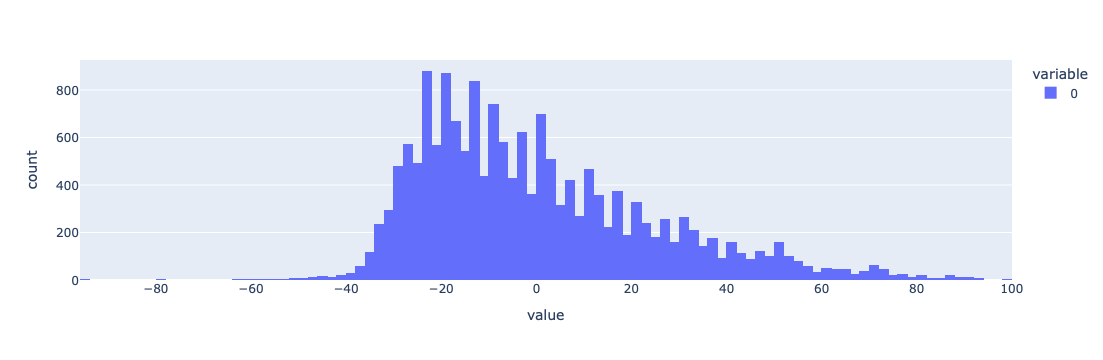

In [169]:
import plotly.express as px
px.histogram(residuals)

In [171]:
from scipy.stats import shapiro
from scipy.stats import jarque_bera

stat, p_value = shapiro(residuals)

print(f"Statystyka testu Shapiro-Wilka: {stat} - Wartość p: {p_value}")

# Interpretacja wyniku
if p_value > 0.05:
    print("Brak dowodów na odrzucenie hipotezy zerowej – reszty pochodzą z rozkładu normalnego.")
else:
    print("Odrzucamy hipotezę zerową – reszty nie pochodzą z rozkładu normalnego.")

stat, p_value = jarque_bera(model.resid)

print(f"Statystyka testu Jarque-Bera: {stat} - Wartość p: {p_value}")

# Interpretacja
if p_value < 0.05:
    print("Odrzucamy hipotezę zerową – dane nie pochodzą z rozkładu normalnego.")
else:
    print("Brak dowodów na odrzucenie hipotezy zerowej – dane mogą pochodzić z rozkładu normalnego.")


Statystyka testu Shapiro-Wilka: 0.9352389596727281 - Wartość p: 1.836314590216661e-64
Odrzucamy hipotezę zerową – reszty nie pochodzą z rozkładu normalnego.
Statystyka testu Jarque-Bera: 2742.9951049572137 - Wartość p: 0.0
Odrzucamy hipotezę zerową – dane nie pochodzą z rozkładu normalnego.


In [173]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(model.resid)
print("Statystyka Durbin-Watsona:", dw_stat)

# Interpretacja
if dw_stat < 1.5:
    print("Pozytywna autokorelacja.")
elif dw_stat > 2.5:
    print("Negatywna autokorelacja.")
else:
    print("Brak autokorelacji.")

Statystyka Durbin-Watsona: 2.004850802277337
Brak autokorelacji.


In [175]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

bp_test = het_breuschpagan(model.resid, model.model.exog)

print("Statystyka testu Breuscha-Pagana:", bp_test[0])
print("Wartość p:", bp_test[1])

if bp_test[1] < 0.05:
    print("Odrzucamy hipotezę zerową – występuje heteroskedastyczność.")
else:
    print("Brak dowodów na heteroskedastyczność.")

white_test = het_white(model.resid, model.model.exog)

print("Statystyka testu Whitea'a:", white_test[0])
print("Wartość p:", white_test[1])

if white_test[1] < 0.05:
    print("Odrzucamy hipotezę zerową – występuje heteroskedastyczność.")
else:
    print("Brak dowodów na heteroskedastyczność.")

Statystyka testu Breuscha-Pagana: 149.65604557447534
Wartość p: 1.58029880346774e-30
Odrzucamy hipotezę zerową – występuje heteroskedastyczność.
Statystyka testu Whitea'a: 320.30988933929626
Wartość p: 1.3523738264267485e-56
Odrzucamy hipotezę zerową – występuje heteroskedastyczność.


In [177]:
# Regresja z błędami robusznymi typu HC3
robust_model = model.get_robustcov_results(cov_type='HC3')

# Wyświetlanie wyników modelu
print(robust_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     337.1
Date:                Thu, 23 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:17:11   Log-Likelihood:                -79158.
No. Observations:               17114   AIC:                         1.583e+05
Df Residuals:                   17108   BIC:                         1.584e+05
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 19

In [179]:
# Calculate RMSE
rmse = np.sqrt(np.mean(model.resid**2))
rmse

24.690676849071266

<Axes: >

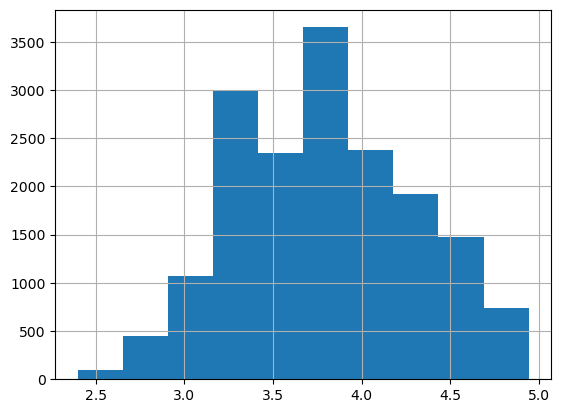

In [181]:
# Possible consideration - logarithm transformation - can help to get better fit??
data_first_model['log_price'] = data_first_model.price.apply(np.log)
data_first_model['log_log_price'] = data_first_model.price.apply(np.log).apply(np.log)

data_first_model.log_price.hist()

## Add some features to model

In [184]:
# Create copy of data
data_second_model = data.copy()

In [186]:
data_second_model.loc[:,['amenities',  'latitude', 'longitude', 'neighbourhood_cleansed']]

,amenities,latitude,longitude,neighbourhood_cleansed
0,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",52.534537,13.402557,Brunnenstr. Süd
1,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",52.548513,13.404553,Prenzlauer Berg Nordwest
2,"{Internet,Wifi,Kitchen,""Buzzer/wireless interc...",52.534996,13.417579,Prenzlauer Berg Südwest
3,"{Internet,Wifi,""Pets allowed"",""Pets live on th...",52.498855,13.349065,Schöneberg-Nord
4,"{Wifi,Heating,""Family/kid friendly"",Essentials...",52.543157,13.415091,Helmholtzplatz
...,...,...,...,...
22547,"{Wifi,""Smoking allowed"",Heating,Essentials,Sha...",52.533865,13.400731,Brunnenstr. Süd
22548,"{TV,Wifi,Kitchen,""Free parking on premises"",""F...",52.496211,13.341738,Schöneberg-Nord
22549,"{Wifi,Kitchen,Heating,Washer,""Fire extinguishe...",52.531800,13.411999,Prenzlauer Berg Südwest
22550,"{Wifi,""Paid parking off premises"",Doorman,Elev...",52.520802,13.378688,Alexanderplatz


### Create features

#### amenities

In [190]:
# Create some features
data['is_wifi']        = data['amenities'].apply(lambda x: 'wifi' in x.lower())*1
data['is_tv']          = data['amenities'].apply(lambda x: 'tv' in x.lower())*1
data['is_essentials']  = data['amenities'].apply(lambda x: 'essentials' in x.lower())*1
data['n_amenities']    = data['amenities'].apply(lambda x: len(x.split(',')))

#### distance

In [193]:
data['lat_dist_mean']  = data['latitude'].apply(lambda x: (x-np.mean( data['latitude']))**2)
data['lon_dist_mean']  = data['longitude'].apply(lambda x: (x-np.mean( data['longitude']))**2)

#### neighbourhood

In [196]:
top_n = 20
data['neighbourhood_cleansed'].value_counts().nlargest(top_n).to_dict()

{'Tempelhofer Vorstadt': 1265,
 'Frankfurter Allee Süd FK': 1240,
 'Reuterstraße': 985,
 'Alexanderplatz': 952,
 'Rixdorf': 873,
 'Neuköllner Mitte/Zentrum': 788,
 'Frankfurter Allee Nord': 704,
 'Brunnenstr. Süd': 698,
 'Schillerpromenade': 649,
 'südliche Luisenstadt': 610,
 'Prenzlauer Berg Nordwest': 594,
 'Prenzlauer Berg Südwest': 563,
 'Schöneberg-Nord': 524,
 'Prenzlauer Berg Süd': 522,
 'Wedding Zentrum': 508,
 'Moabit West': 471,
 'nördliche Luisenstadt': 464,
 'Schöneberg-Süd': 450,
 'Helmholtzplatz': 427,
 'Prenzlauer Berg Nord': 401}

In [198]:
top_nbhds = list(data_second_model['neighbourhood_cleansed'].value_counts().nlargest(top_n).index)
data['neighbourhood_cleansed_map'] = data['neighbourhood_cleansed'].apply(lambda x: x if x in top_nbhds else 'other')

#### property_type

In [201]:
top_n = 6
data['property_type'].value_counts().nlargest(top_n).to_dict()

{'Apartment': 19415,
 'Condominium': 561,
 'Loft': 371,
 'House': 357,
 'Serviced apartment': 125,
 'Hostel': 112}

In [203]:
top_pr_type = list(data['property_type'].value_counts().nlargest(top_n).index)
data['property_type_map'] = data['property_type'].apply(lambda x: x if x in top_pr_type else 'other')

In [205]:
# get all numeric - just string creation
all_num_feats = [x for x in data.dtypes[data.dtypes != 'object'].index if not ('id' in x) and not ('url' in x) and not ('price' in x) ]

In [207]:
print(" \n + ".join(all_num_feats))

host_listings_count 
 + host_total_listings_count 
 + latitude 
 + longitude 
 + accommodates 
 + bathrooms 
 + bedrooms 
 + beds 
 + guests_included 
 + minimum_nights 
 + maximum_nights 
 + availability_30 
 + availability_60 
 + availability_90 
 + availability_365 
 + number_of_reviews 
 + review_scores_rating 
 + review_scores_accuracy 
 + review_scores_cleanliness 
 + review_scores_checkin 
 + review_scores_communication 
 + review_scores_location 
 + review_scores_value 
 + calculated_host_listings_count 
 + reviews_per_month 
 + is_wifi 
 + is_tv 
 + is_essentials 
 + n_amenities 
 + lat_dist_mean 
 + lon_dist_mean


### Model fit

In [210]:
# Our first linear model
model = smf.ols(
    '''price ~ host_listings_count
                   + host_total_listings_count
                   + accommodates
                   + bathrooms
                   + bedrooms
                   + beds
                   + guests_included
                   + minimum_nights
                   + maximum_nights
                   + availability_30
                   + availability_60
                   + availability_90
                   + availability_365
                   + number_of_reviews
                   + review_scores_rating
                   + review_scores_accuracy
                   + review_scores_cleanliness
                   + review_scores_checkin
                   + review_scores_communication
                   + review_scores_location
                   + review_scores_value
                   + calculated_host_listings_count
                   + reviews_per_month
                   + is_wifi
                   + is_tv
                   + is_essentials
                   + n_amenities
                   + C(neighbourhood_cleansed_map,  Treatment(reference="other"))
                   + C(property_type_map,  Treatment(reference="other"))
                   + cancellation_policy
    ''',
    data=data).fit()

# Inspect the results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     233.0
Date:                Thu, 23 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:17:28   Log-Likelihood:                -75785.
No. Observations:               17202   AIC:                         1.517e+05
Df Residuals:                   17145   BIC:                         1.521e+05
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

In [212]:
pd.concat([data.price, model.predict(data).rename('predict')], axis =1)

,price,predict
0,60.0,70.868830
1,17.0,41.319886
2,90.0,69.812710
3,26.0,48.223366
4,42.0,49.967007
...,...,...
22547,60.0,NaN
22548,20.0,NaN
22549,85.0,NaN
22550,99.0,NaN


In [214]:
# RSME
np.sqrt(model.mse_resid)

19.852344005368895

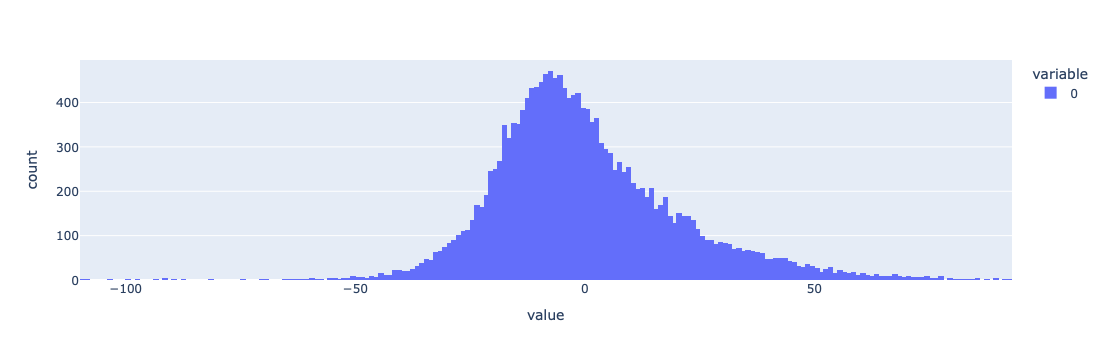

In [216]:
px.histogram(model.resid)

### log_price

In [219]:
# Our first linear model
model = smf.ols(
    '''log_price ~ host_listings_count
                   + host_total_listings_count
                   + latitude
                   + longitude
                   + accommodates
                   + bathrooms
                   + bedrooms
                   + beds
                   + guests_included
                   + minimum_nights
                   + maximum_nights
                   + availability_30
                   + availability_60
                   + availability_90
                   + availability_365
                   + number_of_reviews
                   + review_scores_rating
                   + review_scores_accuracy
                   + review_scores_cleanliness
                   + review_scores_checkin
                   + review_scores_communication
                   + review_scores_location
                   + review_scores_value
                   + calculated_host_listings_count
                   + reviews_per_month
                   + is_wifi
                   + is_tv
                   + is_essentials
                   + n_amenities
                   + lat_dist_mean
                   + lon_dist_mean
                   + neighbourhood_cleansed_map
                   + property_type_map
                   + cancellation_policy
    ''',
    data=data).fit()

# Inspect the results
print(model.summary())

PatsyError: Error evaluating factor: NameError: name 'log_price' is not defined
    log_price ~ host_listings_count                    + host_total_listings_count                    + latitude                    + longitude                    + accommodates                    + bathrooms                    + bedrooms                    + beds                    + guests_included                    + minimum_nights                    + maximum_nights                    + availability_30                    + availability_60                    + availability_90                    + availability_365                    + number_of_reviews                    + review_scores_rating                    + review_scores_accuracy                    + review_scores_cleanliness                    + review_scores_checkin                    + review_scores_communication                    + review_scores_location                    + review_scores_value                    + calculated_host_listings_count                    + reviews_per_month                    + is_wifi                    + is_tv                    + is_essentials                    + n_amenities                    + lat_dist_mean                    + lon_dist_mean                    + neighbourhood_cleansed_map                    + property_type_map                    + cancellation_policy
    ^^^^^^^^^

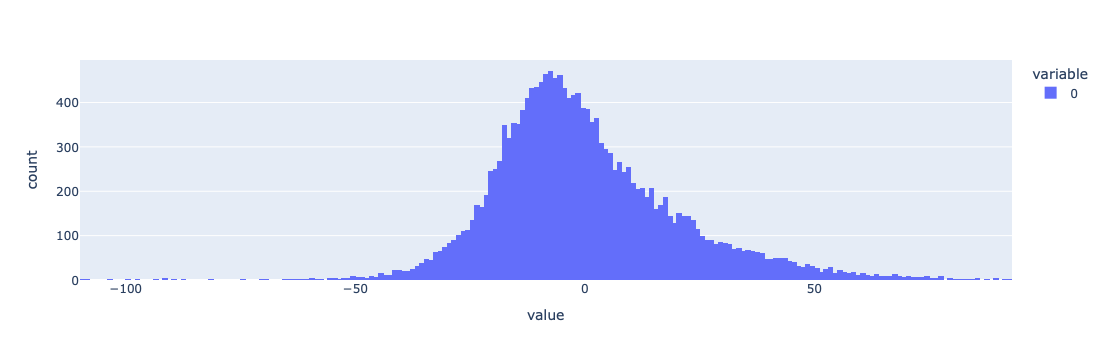

In [221]:
px.histogram(model.resid)

In [223]:
# Calculate residuals
residuals = data['price'] - np.exp(model.predict(model.model.data.frame))

# Calculate RMSE
rmse = np.sqrt(np.mean(residuals**2))
rmse

1.1568793955222823e+74

# Lasso

In [228]:
# Encoding categorical
data.replace({'host_is_superhost' : {'t' : 1, 'f' : 0}}, inplace=True)

(0.00030347479975979466,
 16.340134566220073,
 -0.6433531057816952,
 6.276447948659547)

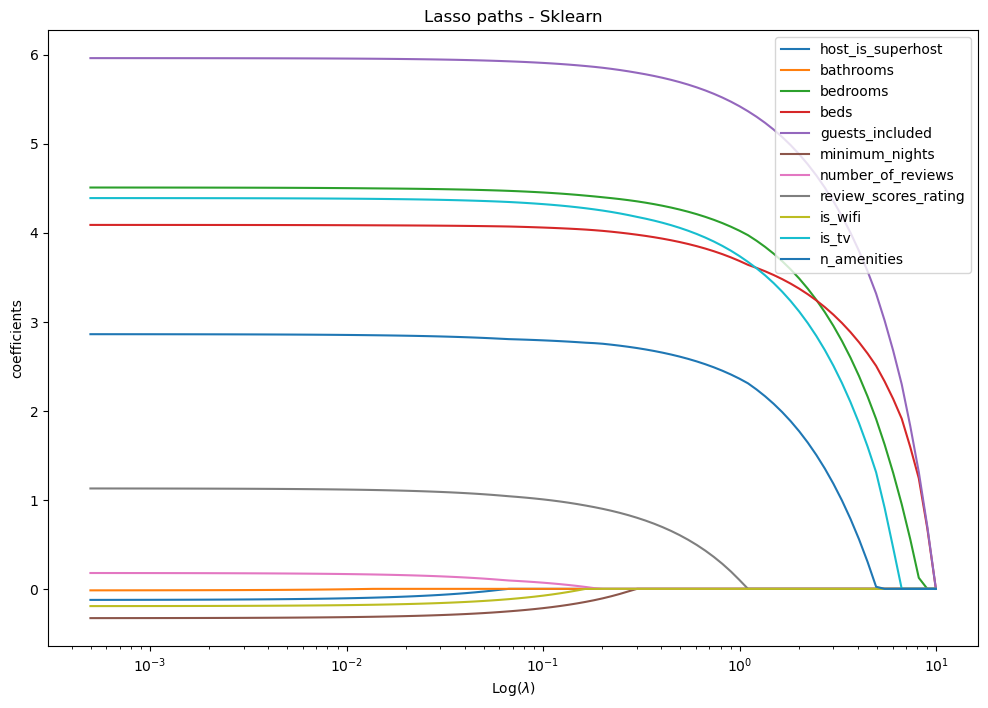

In [230]:
# Lasso

variables = ['host_is_superhost', 'bathrooms', 'bedrooms', 'beds',
             'guests_included', 'minimum_nights', 'number_of_reviews'
             , 'review_scores_rating'] + ['is_wifi', 'is_tv', 'n_amenities']

data_subset = data.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)

X = data_subset.loc[:,variables]
X = preprocessing.scale(X)
y = np.array(data_subset.price)

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps = 5e-5)

# Display results
plt.figure(figsize = (12,8))

for i in range(X.shape[1]):
    plt.plot(alphas_lasso, coefs_lasso[i], label = variables[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

# xgBoost

In [233]:
# XGBoost
variables = ['bathrooms', 'bedrooms', 'beds', 'guests_included', 'minimum_nights', 'number_of_reviews', 'review_scores_rating']

data_subset = data.loc[:, variables + ['price']]
data_subset.dropna(inplace=True)
data_subset = data_subset.iloc[:5000,:]

X = data_subset.loc[:,variables]
#X = preprocessing.scale(X) #We don't have to scale it as trees don't care about distributions, means, and all that smart stuff
y = np.array(data_subset.price)

model = xgboost.XGBRegressor(n_estimators=200, verbosity=1)
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [235]:
X.shape

(5000, 7)

In [237]:
predicted = model.predict(X)
list(zip(data_subset.price[0:10], predicted[0:10]))

[(60.0, 53.809986),
 (17.0, 45.26661),
 (90.0, 85.69241),
 (26.0, 33.103085),
 (42.0, 47.25949),
 (70.0, 64.17019),
 (90.0, 99.079155),
 (45.0, 46.023045),
 (129.0, 106.740814),
 (70.0, 68.45022)]

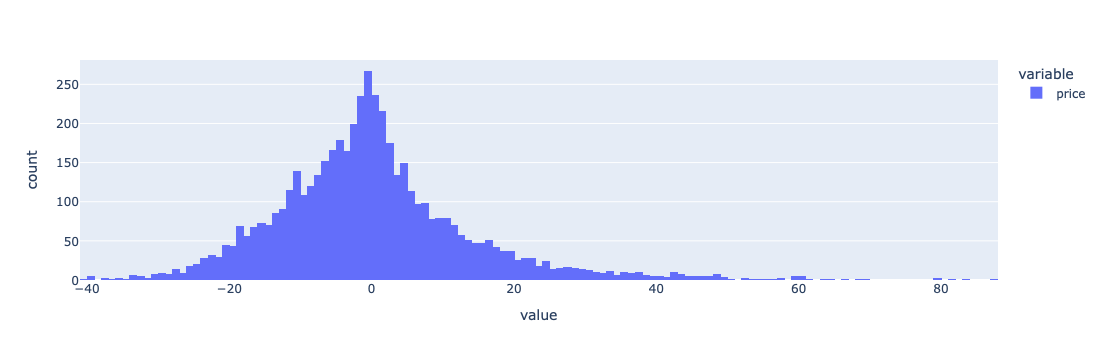

In [239]:
px.histogram( data_subset.price - predicted )

In [241]:
# rmse
np.sqrt(mean_squared_error(y, predicted))
#What does it even mean? Todo: check different error functions and how they can be explained
#Did we do a proper training and prediction? NO - we need to have proper TRAIN and TEST sets! Todo at home ;)

13.717516238709928

# XAI - Shapley values

In [244]:
#Playing with Shapley values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

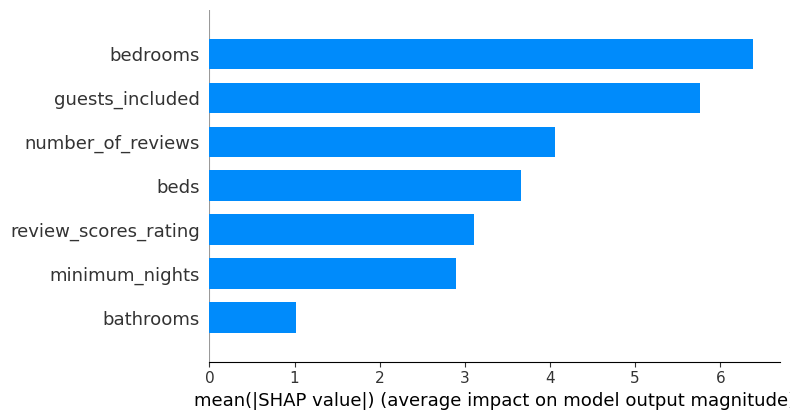

In [245]:
shap.summary_plot(shap_values, X, plot_type="bar")

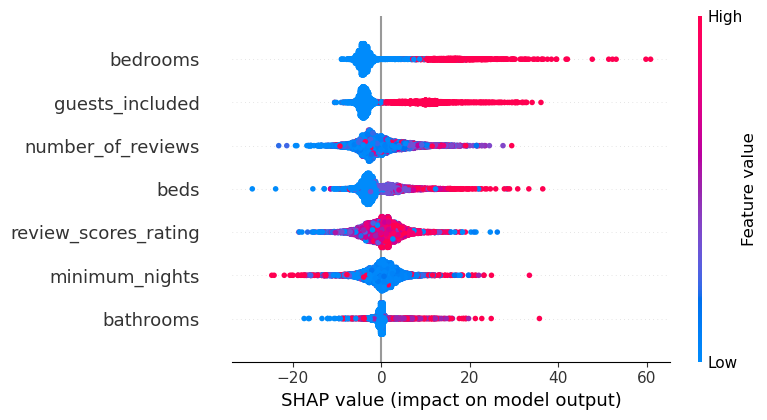

In [248]:
#From official documentation:
'''The summary plot combines feature importance with feature effects.
Each point on the summary plot is a Shapley value for a feature and an instance.
The position on the y-axis is determined by the feature and on the x-axis by the Shapley value.
The color represents the value of the feature from low to high.
Overlapping points are jittered in y-axis direction, so we get a sense of the distribution
of the Shapley values per feature. The features are ordered according to their importance.'''
# So from this plot we can read that guests_included and bedrooms are the most important variables
#    and high number of guests_included/bedrooms is linked to higher price
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

In [250]:
X.iloc[2,:]

bathrooms                 1.0
bedrooms                  1.0
beds                      2.0
guests_included           2.0
minimum_nights           62.0
number_of_reviews       143.0
review_scores_rating     92.0
Name: 2, dtype: float64

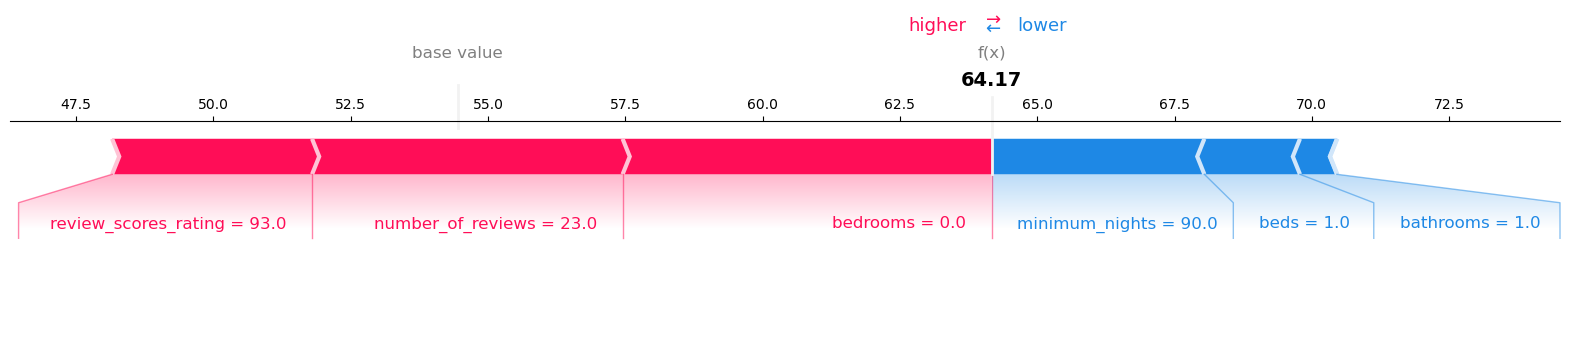

In [252]:
shap.force_plot(explainer.expected_value, shap_values[5,:], X.iloc[5,:], matplotlib=True)

In [254]:
X.iloc[10,:]

bathrooms                1.0
bedrooms                 2.0
beds                     2.0
guests_included          2.0
minimum_nights           3.0
number_of_reviews       61.0
review_scores_rating    94.0
Name: 13, dtype: float64

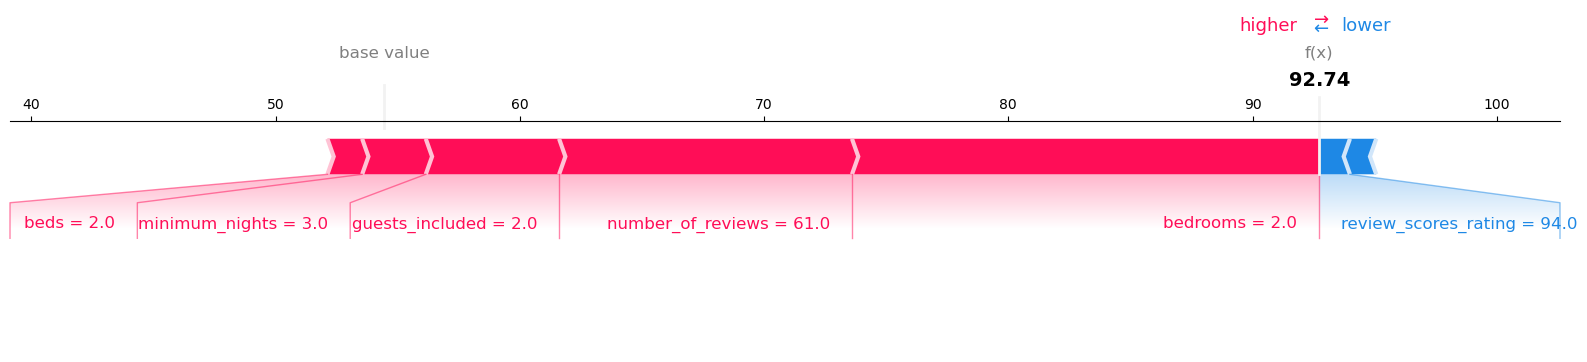

In [256]:
shap.force_plot(explainer.expected_value, shap_values[10,:], X.iloc[10,:], matplotlib=True)